💾 0. Load & Preproces

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Segoe UI Emoji'  # For Windows
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Load data
df = pd.read_csv("bestSelling_games.csv")

# Extract primary genre
df["primary_genre"] = df["user_defined_tags"].str.split(",").str[0].str.strip()

# Optional: parse release date
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["release_year"] = df["release_date"].dt.year

🔢 1. Feature Scaling & Clusterin

In [9]:
features = df[["difficulty", "length", "estimated_downloads", "rating", "all_reviews_number"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=5, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Assign readable labels
df["cluster_label"] = df["cluster"].map({
    0: "Mass Appeal Machines",
    1: "The Skill Gauntlet",
    2: "Competitive Chaos",
    3: "Narrative Niche",
    4: "Sandbox Explorers"
})

📉 2. PCA Visualizatio

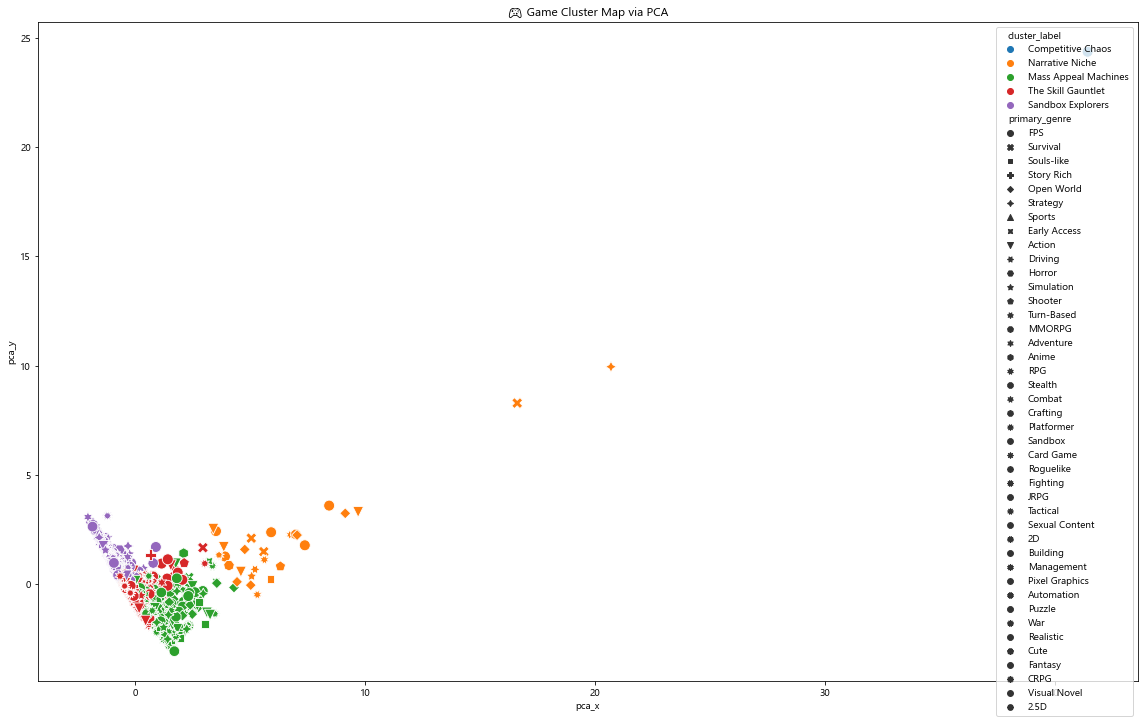

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df["pca_x"] = X_pca[:, 0]
df["pca_y"] = X_pca[:, 1]

plt.figure(figsize=(16, 11))
sns.scatterplot(data=df, x="pca_x", y="pca_y", hue="cluster_label", style="primary_genre", s=120)
plt.title("🎮 Game Cluster Map via PCA")
plt.tight_layout()
plt.show()

📊 3. Cluster Summarie

In [12]:
# Mean stats per cluster
summary = df.groupby("cluster")[["difficulty", "length", "estimated_downloads", "rating", "all_reviews_number"]].mean().round(2)

# Dominant genre per cluster
top_genres = df.groupby("cluster")["primary_genre"].agg(lambda x: x.mode().iloc[0])
summary["dominant_genre"] = top_genres
summary["size"] = df["cluster"].value_counts().sort_index()
print("📌 Cluster Profile Summary:")
print(summary)

📌 Cluster Profile Summary:
         difficulty  length  estimated_downloads  rating  all_reviews_number  \
cluster                                                                        
0              3.43   56.16         3.950712e+06    3.66            52168.86   
1              3.09   14.98         1.386726e+06    3.56            14173.10   
2              4.00   80.00         3.061700e+08    3.20          8803754.00   
3              3.32   61.64         6.801536e+07    3.77           767020.18   
4              2.13   10.52         3.439276e+05    2.42             3780.66   

        dominant_genre  size  
cluster                       
0             Strategy   508  
1               Action  1106  
2                  FPS     1  
3                  FPS    28  
4           Simulation   737  


🔥 4. Genre Heatmap

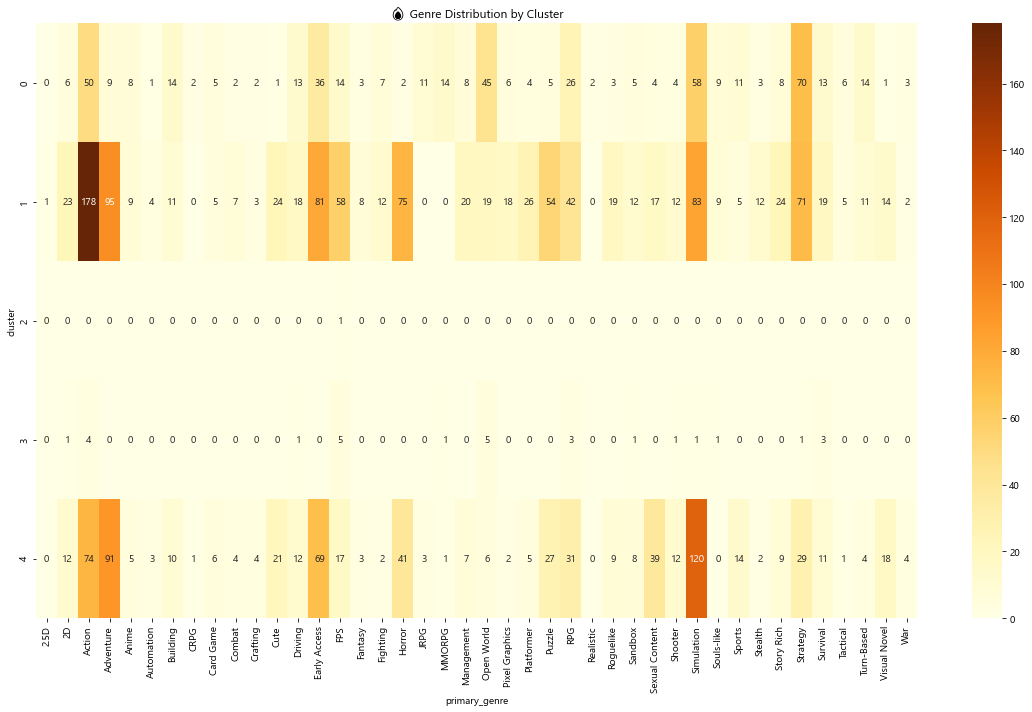

In [14]:
genre_matrix = df.groupby("cluster")["primary_genre"].value_counts().unstack().fillna(0)
plt.figure(figsize=(16, 10))
sns.heatmap(genre_matrix, cmap="YlOrBr", annot=True, fmt=".0f")
plt.title("🔥 Genre Distribution by Cluster")
plt.tight_layout()
plt.show()

🎯 5. Game Similarity Engin

In [15]:
target_game = "ELDEN RING NIGHTREIGN"
target_vec = X_scaled[df["game_name"] == target_game]

similarities = cosine_similarity(target_vec, X_scaled)[0]
df["similarity"] = similarities

top_similar = df.sort_values("similarity", ascending=False)[1:6]
print("🔍 Games similar to", target_game)
print(top_similar[["game_name", "primary_genre", "rating", "difficulty", "similarity"]])

🔍 Games similar to ELDEN RING NIGHTREIGN
                   game_name primary_genre  rating  difficulty  similarity
270   ARK: Survival Ascended  Early Access    4.00           4    0.997097
139               Victoria 3      Strategy    4.05           4    0.996525
2097             Dice Legacy      Building    4.50           5    0.994914
198                   RIDE 4        Sports    4.50           5    0.994073
1261             Mechabellum      Strategy    4.00           4    0.994048


🧪 6. Recommender (Custom Vector

In [17]:
# User-defined preferences
custom = np.array([[4, 75, 15000000, 4.5, 1000000]])  # High difficulty + long playtime

custom_scaled = scaler.transform(custom)
custom_cluster = kmeans.predict(custom_scaled)[0]

recs = df[df["cluster"] == custom_cluster].sort_values("rating", ascending=False).head(5)
print("🤖 Recommended Games Based on Preferences:")
print(recs[["game_name", "primary_genre", "rating", "difficulty", "length"]])

🤖 Recommended Games Based on Preferences:
          game_name primary_genre  rating  difficulty  length
357   Sultan's Game           RPG    4.59           4      47
1184   Songs of Syx  Early Access    4.57           3      80
428            Elin  Early Access    4.50           2      67
198          RIDE 4        Sports    4.50           5      67
2097    Dice Legacy      Building    4.50           5      70


📅 7. Timeline Trends

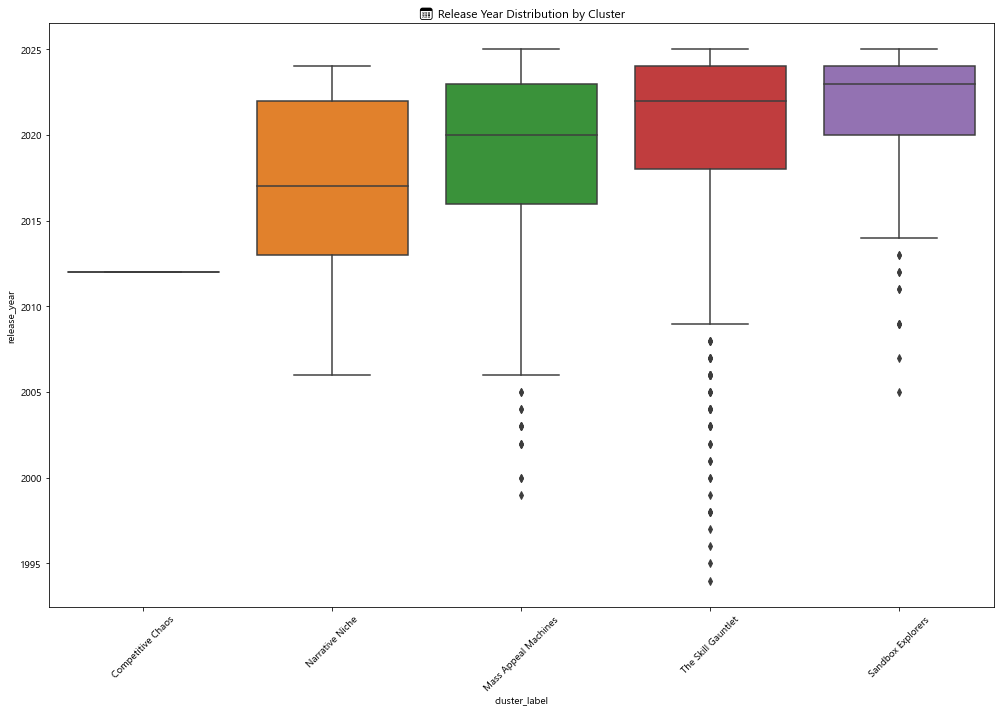

In [20]:
plt.figure(figsize=(14, 10))
sns.boxplot(x="cluster_label", y="release_year", data=df)
plt.title("📅 Release Year Distribution by Cluster")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()